### Set working directory

In [2]:
import os
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml


### Read & Vis example image

In [3]:
from glob import glob

img_dir = "artifacts/data_ingestion/norm_images"
img_files = glob(f"{img_dir}/*.png")
print(f"Number of images: {len(img_files)}")

Number of images: 200


IDX: 172


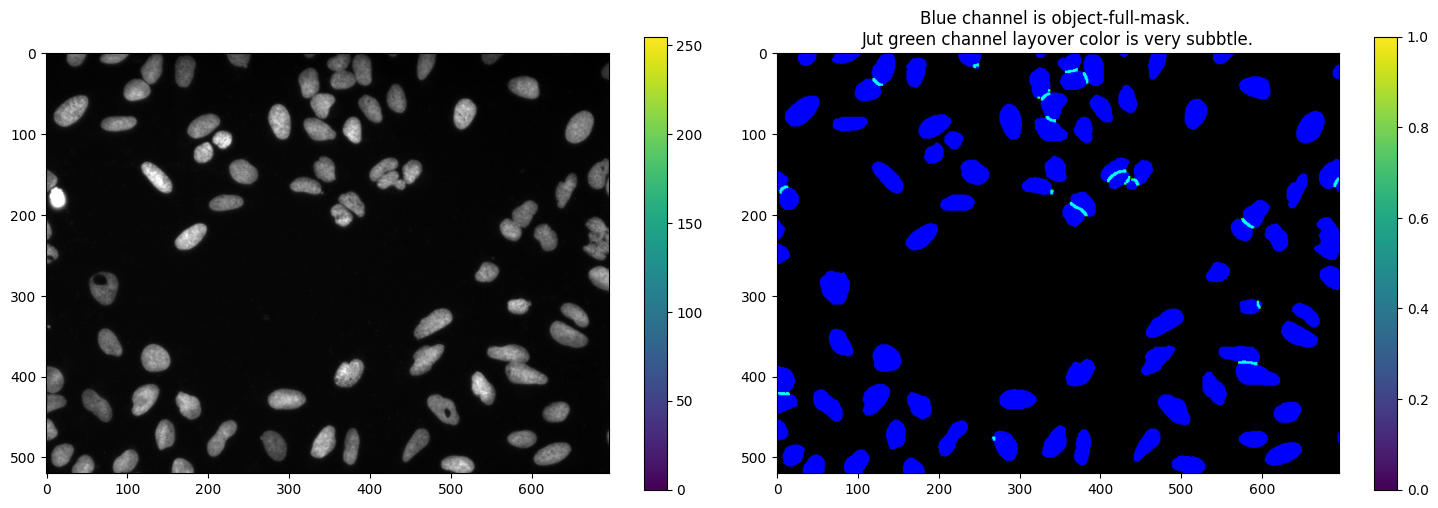

In [4]:
import random
import matplotlib.pyplot as plt
from mwm.components.image_processing import read_image_png, get_gt_mask_png

IDX = 172 # random.randint(0, len(img_files))
print(f"IDX: {IDX}")

img = read_image_png(img_files[IDX])

mask_dir = "artifacts/data_ingestion/masks"
mask_raw = read_image_png(os.path.join(mask_dir, os.path.basename(img_files[IDX])))
mask_png = get_gt_mask_png(mask_raw[:,:,0])
mask_gt = mask_png[:,:,1:] # leave out the 1st channel (empty), [0 1]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(img), ax=ax[0])
fig.colorbar(ax[1].imshow(mask_png), ax=ax[1])
ax[1].set_title("Blue channel is object-full-mask. \nJut green channel layover color is very subbtle.")
plt.tight_layout()
plt.show()

### Vis & Understand signed distance map (SDMs)

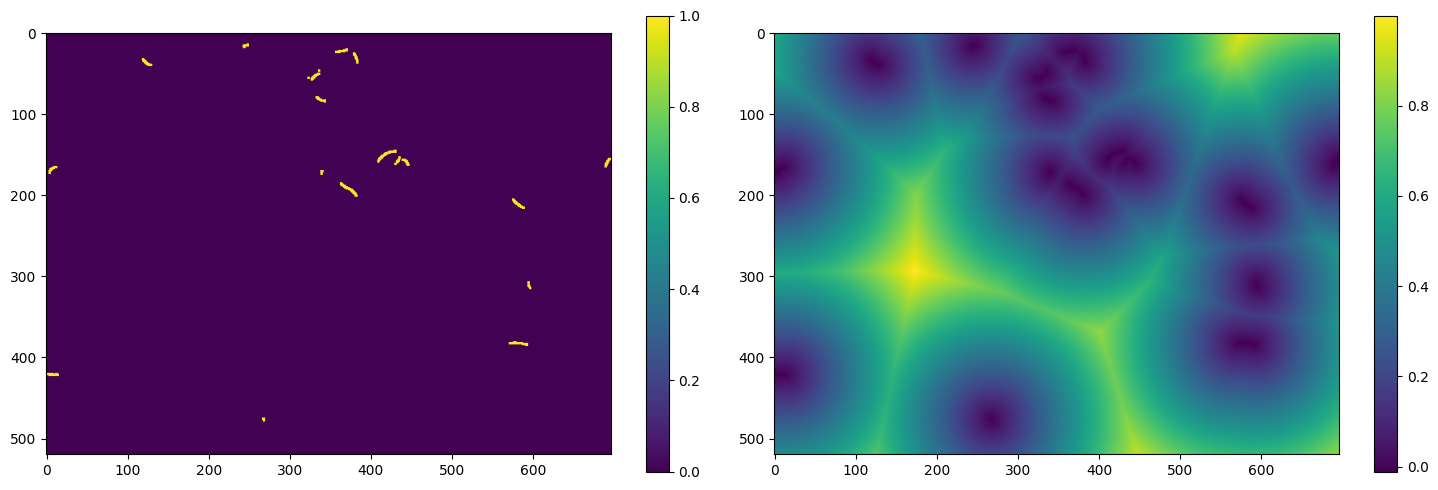

In [5]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def compute_sdm(mask):
    """
    Compute signed distance map (SDM) from boundary mask.
    Args:
        mask: Binary numpy array (H, W), 1 for boundary pixels, 0 elsewhere
    """
    posmask = mask.astype(bool)
    negmask = ~posmask
    sdm = distance_transform_edt(negmask) - distance_transform_edt(posmask)

    max_val = np.max(np.abs(sdm))
    sdm = sdm / (max_val + 1e-6) # Normalize to [-1, 1]

    return sdm

# Example usage
boundary_mask = mask_gt[:,:,0] # 1 for boundary pixels, 0 elsewhere
sdm = compute_sdm(boundary_mask)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.colorbar(ax[0].imshow(boundary_mask), ax=ax[0])
fig.colorbar(ax[1].imshow(sdm), ax=ax[1])
plt.tight_layout()
plt.show()

# Save SDM (float32)
# np.save('boundary_mask_sdm.npy', sdm)


### Pre-compute SDMs
 * Needed only for training set (but include val too in case we do cross-validation later)
 * Why not compute DT on the fly in loss function?
    1. Distance Transform (DT) is Non-Differentiable. So it blocks gradients → breaks learning.
    2. DT is CPU-based (non-PyTorch-native) → if done at runtime, you'd have:
        - CPU bottlenecks.
        - Frequent CPU-GPU data transfer (slow!). 

In [6]:
save_path = "artifacts/data_ingestion/sdms"

with open("artifacts/data_ingestion/metadata/training.txt", "r") as f:
    train_img_list = f.read().splitlines()
print(len(train_img_list))

with open("artifacts/data_ingestion/metadata/validation.txt", "r") as f:
    val_img_list = f.read().splitlines()
print(len(val_img_list))

img_list = train_img_list + val_img_list
print(len(img_list))

98
49
147


In [ ]:
# Pre-compute (one-off)

for filename in img_list:
    mask_raw = read_image_png(os.path.join(mask_dir, filename))
    mask_png = get_gt_mask_png(mask_raw[:,:,0])
    boundary_mask = mask_png[:,:,1]
    sdm = compute_sdm(boundary_mask)
    # np.save(os.path.join(save_path, filename.split(".")[0]), sdm.astype(np.float32))